In [63]:
import tensorflow as tf
from keras.layers import *
import math
import zipfile
import numpy as np
import random
import tensorflow.keras.backend as K
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [64]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = 'data-science-bowl-2018/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
# Unzip data
with zipfile.ZipFile(UNZIP_PATH+'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile(UNZIP_PATH+'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [65]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [66]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

In [67]:
# Resize images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(
        img, (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    
    X_train[n] = img # fill empty X_train with values from img 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(
            resize(
                mask_, 
                (IMG_HEIGHT, IMG_WIDTH), 
                mode = 'constant', 
                preserve_range = True
            ), 
            axis = -1
        )
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [02:58<00:00,  3.76it/s]


In [68]:
# test images
X_test = np.zeros(
    (
        len(test_ids), 
        IMG_HEIGHT, 
        IMG_WIDTH, 
        IMG_CHANNELS
    ), 
    dtype = np.uint8
)

sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(
        img, 
        (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    X_test[n] = img

100%|██████████| 65/65 [00:00<00:00, 70.77it/s]


In [88]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def sensitivity(y_true, y_pred):        
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def plot_metrics_for_training(history):
    
    plt.figure(figsize=(30, 15))
    plt.subplot(411)
    plt.plot(history['dice_coef'], label='dice_coef')
    plt.plot(history['val_dice_coef'], label = 'val_dice_coef')
    plt.xticks(np.arange(len(history['dice_coef'])), np.arange(1, len(history['dice_coef'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('dice score')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(412)
    plt.plot(history['sensitivity'], label='sensitivity')
    plt.plot(history['specificity'], label = 'specificity')
    plt.xticks(np.arange(len(history['sensitivity'])), np.arange(1, len(history['sensitivity'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity and Specificity')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(413)
    plt.plot(history['val_sensitivity'], label='val_sensitivity')
    plt.plot(history['val_specificity'], label = 'val_specificity')
    plt.xticks(np.arange(len(history['val_sensitivity'])), np.arange(1, len(history['val_sensitivity'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('val_Sensitivity and val_Specificity')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

In [96]:
def ConvBnLayer(x, oup, kernel_size, stride, padding='same'):
    y = Conv2D(filters=oup, kernel_size=kernel_size, strides=stride, padding=padding)(x)
    #y = BatchNormalization(epsilon=1e-5, momentum=0.1)(y)
    return y

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def SELayer(x, reduction=4):
    batch, _, __, channel = x.shape
    y = GlobalAveragePooling2D()(x)
    y = Dense(units=channel // reduction, activation='relu')(y)
    y = Dense(units=channel, activation='sigmoid')(y)
    y = Reshape([1, 1, channel])(y)
    se_tensor = Multiply()([x, y])
    return se_tensor


def DepthWiseConv(x, kernel_size=3, stride=1, depth_multiplier=1, padding='same', relu=False):
    y = DepthwiseConv2D(kernel_size=kernel_size // 2, depth_multiplier=depth_multiplier,
                        strides=stride, padding=padding)(x)
    y = BatchNormalization(epsilon=1e-5, momentum=0.1)(y)
    if relu:
        y = Activation('relu')(y)
    return y


def GhostModule(x, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
    init_channels = math.ceil(oup / ratio)
    new_channels = init_channels * (ratio - 1)

    multiplier = new_channels // init_channels

    primary_tensor = ConvBnLayer(x, init_channels, kernel_size=kernel_size, stride=stride, padding='same')
    if relu:
        primary_tensor = Activation('relu')(primary_tensor)

    cheap_tensor = DepthWiseConv(primary_tensor, kernel_size=dw_size,
                                 depth_multiplier=multiplier, padding='same', stride=1)
    if relu:
        cheap_tensor = Activation('relu')(cheap_tensor)

    out = Concatenate()([primary_tensor, cheap_tensor])
    return Lambda(lambda x: x[:, :, :, :oup])(out)

def GhostBottleneck(x, hidden_dim, oup, kernel_size, stride, use_se):
    assert stride in [1, 2]
    inp = x.shape[-1]
    if stride == 1 and inp == oup:
        shortcut = x
    else:
        shortcut = DepthWiseConv(x, kernel_size=3, stride=stride, relu=False)
        shortcut = ConvBnLayer(shortcut, oup, 1, 1, padding='same')

    x = GhostModule(x, hidden_dim, kernel_size=1, relu=True)
    if stride == 2:
        x = DepthWiseConv(x, kernel_size, stride, relu=False)
    if use_se:
        x = SELayer(x)
    x = GhostModule(x, oup, kernel_size=1, relu=False)
    return Add()([x, shortcut])


def ghosted_layer(x,filters):
    cfgs =[3, 1, 1, 1] # k, t, SE, s
    
    output_channel = filters
    #x = ConvBnLayer(x, output_channel, 3, 2, padding='same')
    output_channel = _make_divisible(filters * 1.55, 4)
    hidden_channel = _make_divisible(cfgs[1] * 2, 4)
    x = GhostBottleneck(x, hidden_channel, output_channel, cfgs[0], cfgs[3], cfgs[2])
    print(f'Input Features: {filters}, Ghosted UNET Features: {output_channel}')
    return x

In [130]:
def UNET_ghosted_UNET(ghosted_flag):
    name_of_model=['UNET','Ghosted_UNET']     
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization
    if (ghosted_flag==0):
        # Contraction path
        c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
        p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

        c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
        p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

        c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
        p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

        c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
        p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

        c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

    else: 
        #c1 = tf.keras.layers.Conv2D(8, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
        c1=ghosted_layer(s,16)
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1=ghosted_layer(c1,16)
        #c1=ghosted_layer(c1,16)
        p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

        c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
        c2=ghosted_layer(c2,32)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        #c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
        c2=ghosted_layer(c2,32)
        p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

        c3=ghosted_layer(p2,64)
        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3=ghosted_layer(c3,64)
        p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

        c4=ghosted_layer(p3,128)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4=ghosted_layer(c4,128)
        p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

        c5=ghosted_layer(p4,256)
        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5=ghosted_layer(c5,256)
        c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

 
    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs],name=name_of_model[ghosted_flag])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,sensitivity,specificity])
    model.summary()
    return model

In [131]:
# Callbacks
u_net_model=UNET_ghosted_UNET(0)
checkpointer = tf.keras.callbacks.ModelCheckpoint(str(u_net_model.name)+'.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience =5, monitor='val_dice_coef', mode='max',restore_best_weights=True),
    checkpointer
]


Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_532 (Lambda)            (None, 128, 128, 3)  0           ['input_33[0][0]']               
                                                                                                  
 conv2d_1033 (Conv2D)           (None, 128, 128, 16  448         ['lambda_532[0][0]']             
                                )                                                                 
                                                                                               

In [132]:
ghosted_u_net_model=UNET_ghosted_UNET(1)
checkpointer_ghosted = tf.keras.callbacks.ModelCheckpoint(str(ghosted_u_net_model.name)+'.h5', verbose = 1, save_best_only = True)
callbacks_ghosted = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor='val_dice_coef', mode='max',restore_best_weights=True),
    checkpointer_ghosted
]

Input Features: 16, Ghosted UNET Features: 24
Input Features: 16, Ghosted UNET Features: 24
Input Features: 32, Ghosted UNET Features: 48
Input Features: 32, Ghosted UNET Features: 48
Input Features: 64, Ghosted UNET Features: 100
Input Features: 64, Ghosted UNET Features: 100
Input Features: 128, Ghosted UNET Features: 200
Input Features: 128, Ghosted UNET Features: 200
Input Features: 256, Ghosted UNET Features: 396
Input Features: 256, Ghosted UNET Features: 396
Model: "Ghosted_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_533 (

In [133]:
results = u_net_model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.3, 
    batch_size = 32, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.6596 - dice_coef: 0.3103 - sensitivity: 0.0966 - specificity: 0.9272
Epoch 1: val_loss improved from inf to 0.63311, saving model to UNET.h5
15/15 [==============================] - 22s 1s/step - loss: 0.6596 - dice_coef: 0.3103 - sensitivity: 0.0966 - specificity: 0.9272 - val_loss: 0.6331 - val_dice_coef: 0.2990 - val_sensitivity: 9.1192e-06 - val_specificity: 1.0000
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.5742 - dice_coef: 0.2991 - sensitivity: 0.0252 - specificity: 0.9967
Epoch 2: val_loss improved from 0.63311 to 0.50392, saving model to UNET.h5
15/15 [==============================] - 19s 1s/step - loss: 0.5742 - dice_coef: 0.2991 - sensitivity: 0.0252 - specificity: 0.9967 - val_loss: 0.5039 - val_dice_coef: 0.3187 - val_sensitivity: 0.0691 - val_specificity: 0.9985
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.4326 - dice_coef: 0.3871 - sensitivity: 0.1622

In [ ]:
results_ghosted=ghosted_u_net_model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.3, 
    batch_size = 32, 
    epochs = 25, 
    callbacks = callbacks_ghosted)

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.4778 - dice_coef: 0.3744 - sensitivity: 0.1705 - specificity: 0.9788
Epoch 1: val_loss improved from inf to 0.39882, saving model to Ghosted_UNET.h5
15/15 [==============================] - 51s 3s/step - loss: 0.4778 - dice_coef: 0.3744 - sensitivity: 0.1705 - specificity: 0.9788 - val_loss: 0.3988 - val_dice_coef: 0.4639 - val_sensitivity: 0.3366 - val_specificity: 0.9795
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.3731 - dice_coef: 0.5535 - sensitivity: 0.5854 - specificity: 0.9456
Epoch 2: val_loss did not improve from 0.39882
15/15 [==============================] - 36s 2s/step - loss: 0.3731 - dice_coef: 0.5535 - sensitivity: 0.5854 - specificity: 0.9456 - val_loss: 0.4062 - val_dice_coef: 0.6259 - val_sensitivity: 0.6600 - val_specificity: 0.9283
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.2869 - dice_coef: 0.6490 - sensitivity: 0.7655 - specificity: 0.9374
Ep

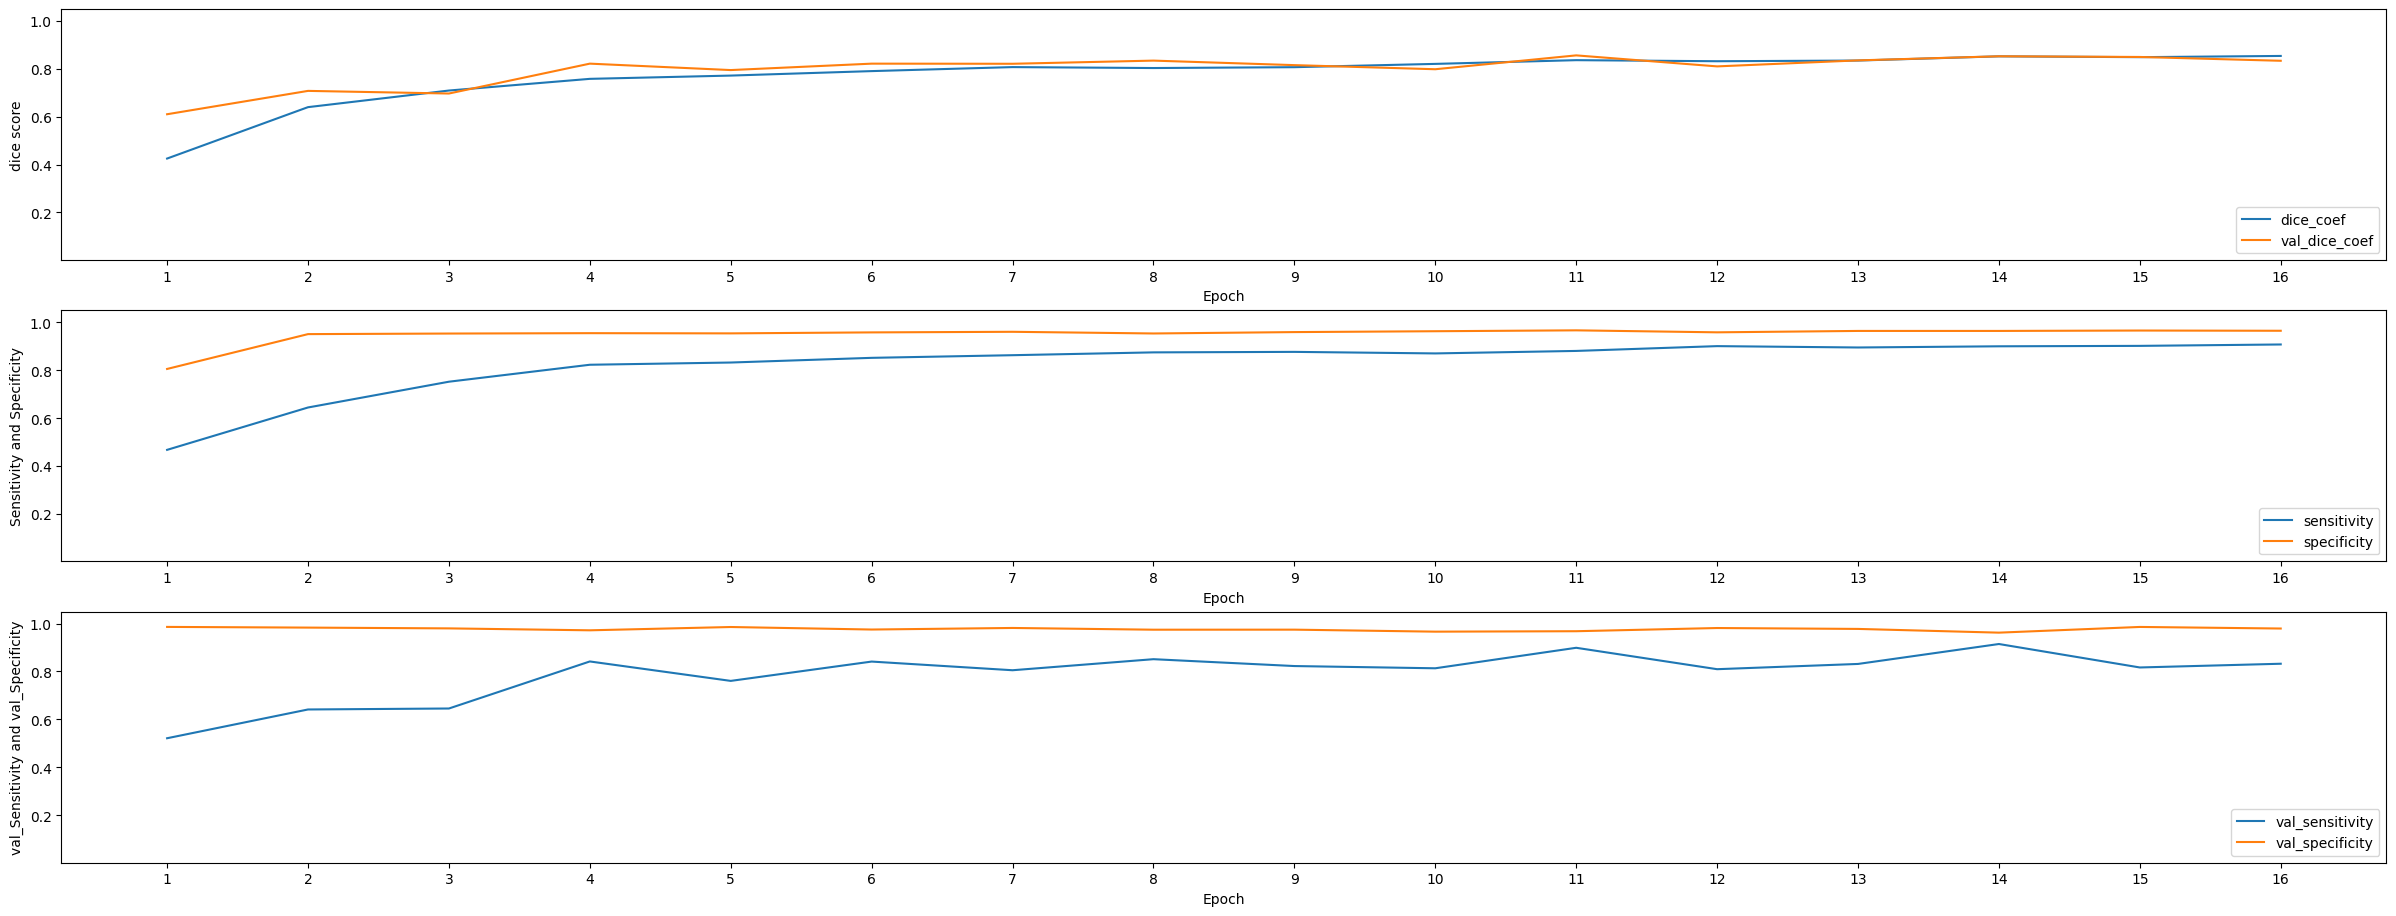

In [ ]:
plot_metrics_for_training(results.history)

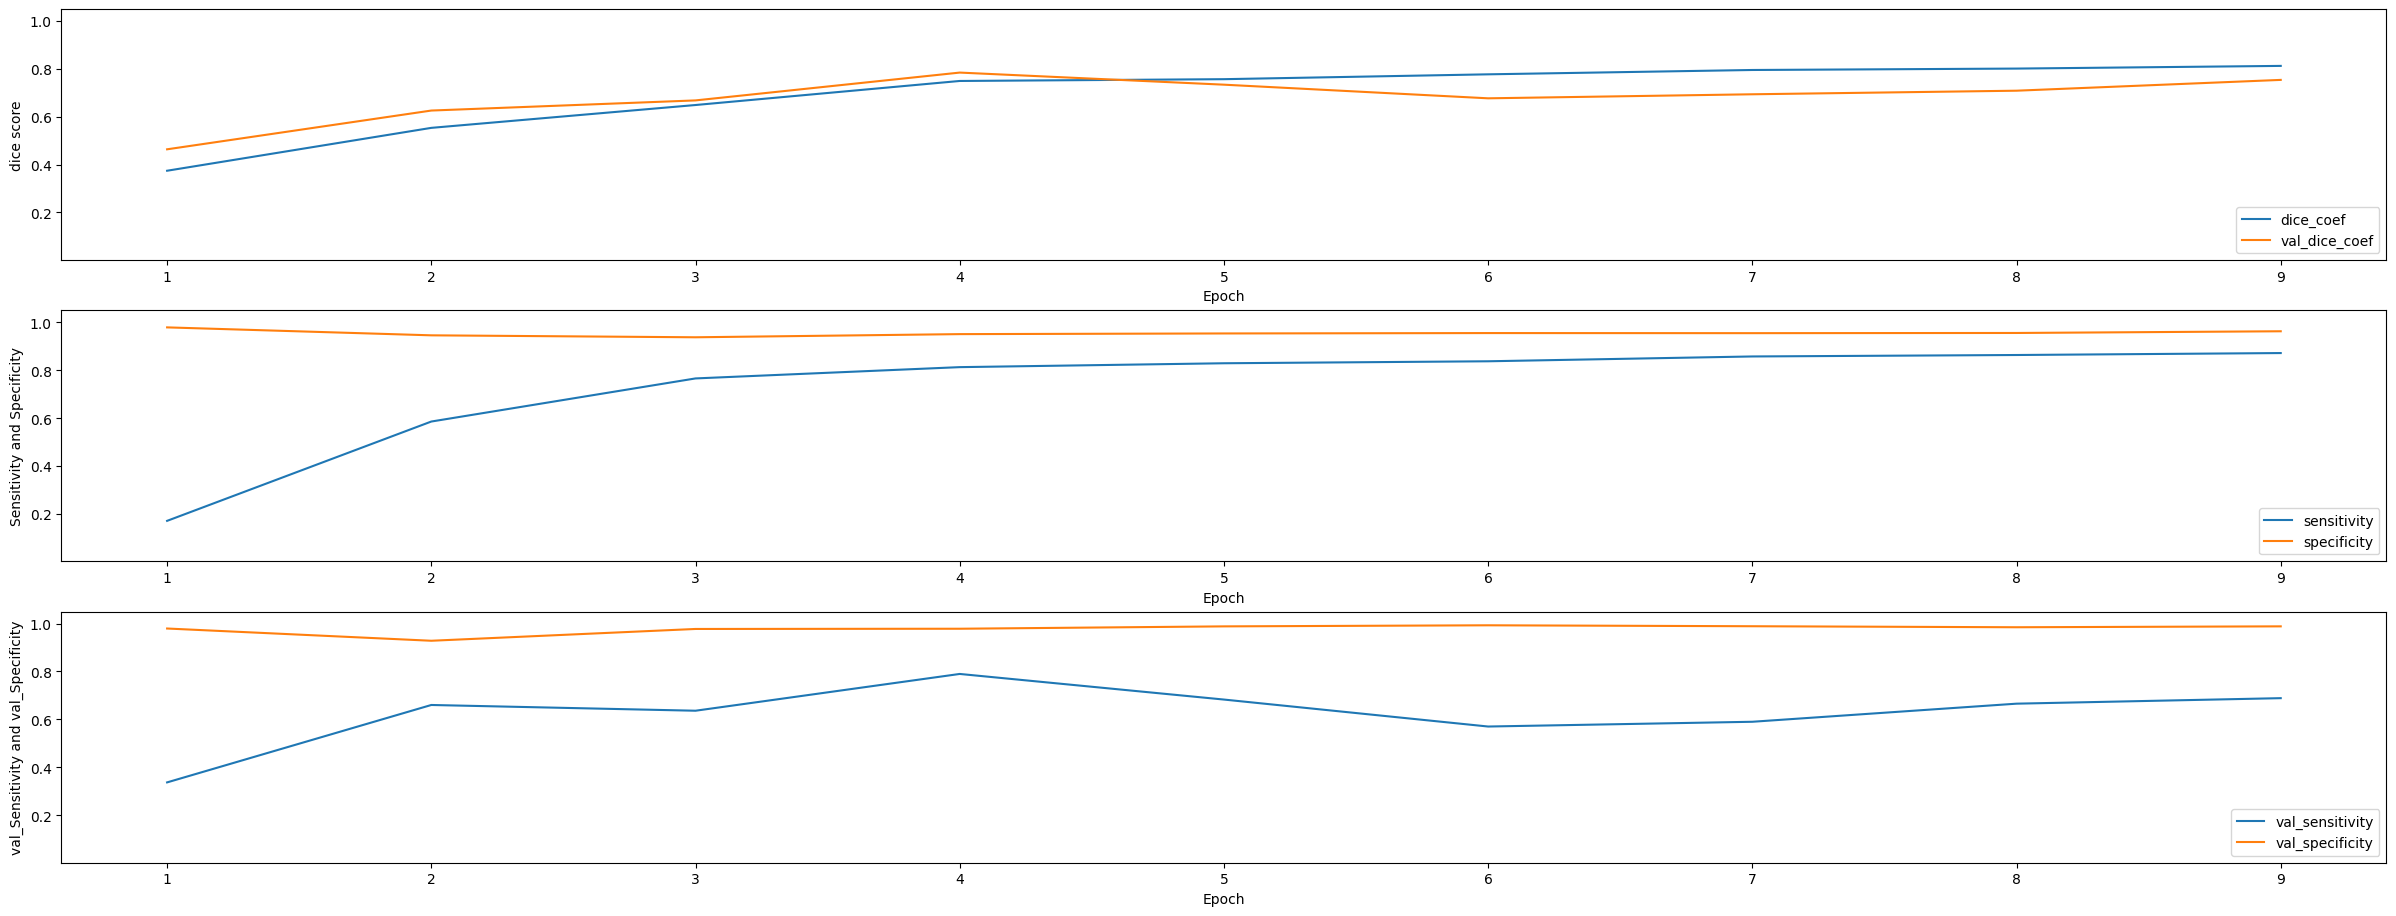

In [ ]:
plot_metrics_for_training(results_ghosted.history)

<h3> Inference Testing </h3>

<p> <b> Note:</b>  Need to build a better Inference testing so that I can test the models on real time data maybe the issue is with the data but will work it out next </p>

In [116]:
# Predictions
idx = random.randint(0, len(X_train))

u_net_preds_train = u_net_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
u_net_preds_val = u_net_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
u_net_preds_test = u_net_model.predict(X_test, verbose = 1)

u_net_preds_train_t = (u_net_preds_train > 0.5).astype(np.uint8)
u_net_preds_val_t = (u_net_preds_val > 0.5).astype(np.uint8)
u_net_preds_test_t = (u_net_preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 204ms/step


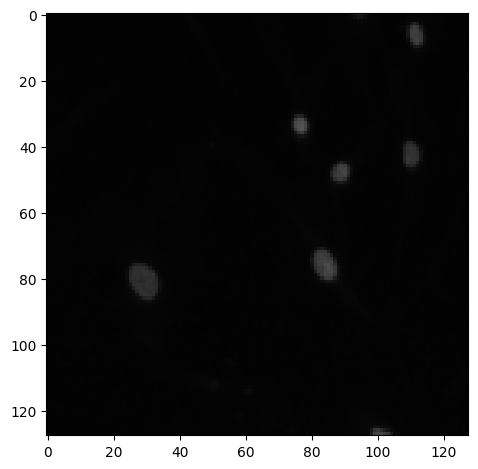

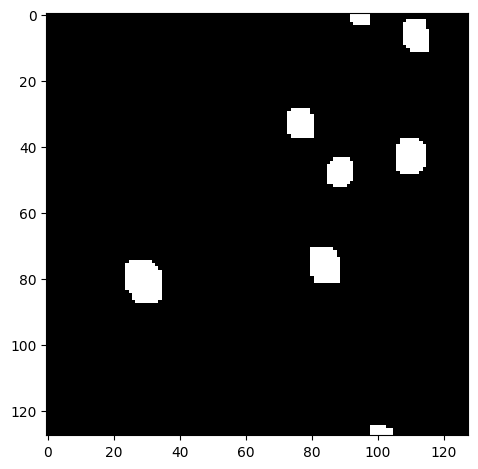

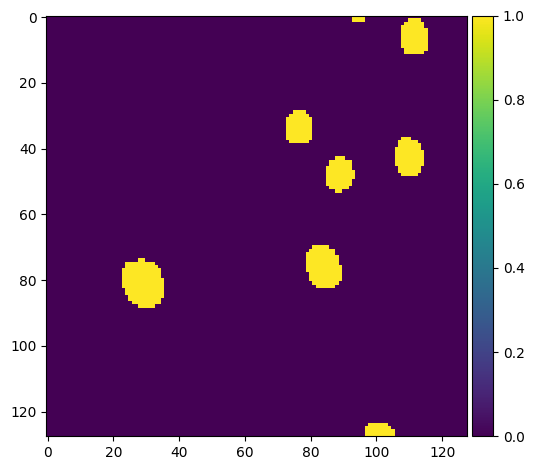

In [129]:
# Sanity check on random training samples
ix = random.randint(0, len(u_net_preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(u_net_preds_train_t[ix]))
plt.show()